# Dask processing tests

this needs graphviz for visualizations

In [1]:
import dask
import dask.array as da
import numpy as np


## define a computational graph
embarassingly parallel here 

In [14]:
def f(x):
    return x + 1

def g(x):
    return x * 2

def h(x):
    return x - 3

def m(x):  
    return da.mean(x)  # we can also use numpy.mean here if we want, but the latter will directly materialize the array. da.mean needs a 'compute' call to materialize the array instead

def identity(x):
    return x

In [3]:
f_delayed = dask.delayed(f)
g_delayed = dask.delayed(g)
h_delayed = dask.delayed(h)
m_delayed = dask.delayed(m)

In [4]:
input_placeholder = dask.delayed(identity, pure = True)(da.arange(2))
fx = f_delayed(input_placeholder)
gx = g_delayed(fx)
hx = h_delayed(gx)
mx = m_delayed(hx)
input_key = input_placeholder.key
computation = mx 
graph = dict(computation.dask)

In [5]:
input_key

'identity-a6a84f881da07f5791b1695d91e07114'

In [6]:
computation

Delayed('m-424caf63-77cc-4c18-9ff6-9b8256032a59')

In [7]:
graph

{'identity-a6a84f881da07f5791b1695d91e07114': <Task 'identity-a6a84f881da07f5791b1695d91e07114' identity(...)>,
 'arange-finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b-4f00fe128e6c4d0cb88b35b6219db108': <Task 'arange-finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b-4f00fe128e6c4d0cb88b35b6219db108' _identity(...)>,
 'finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b-4f00fe128e6c4d0cb88b35b6219db108': <Task 'finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b-4f00fe128e6c4d0cb88b35b6219db108' _identity(...)>,
 'arange-finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b': <Task 'arange-finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b' _execute_subgraph(...)>,
 'finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b': Alias('finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b'->'arange-finalize-hlgfinalizecompute-169910bd98c4433993ceb9965139a15b'),
 'f-5227683a-0004-4891-bffe-4c5c192e3951': <Task 'f-5227683a

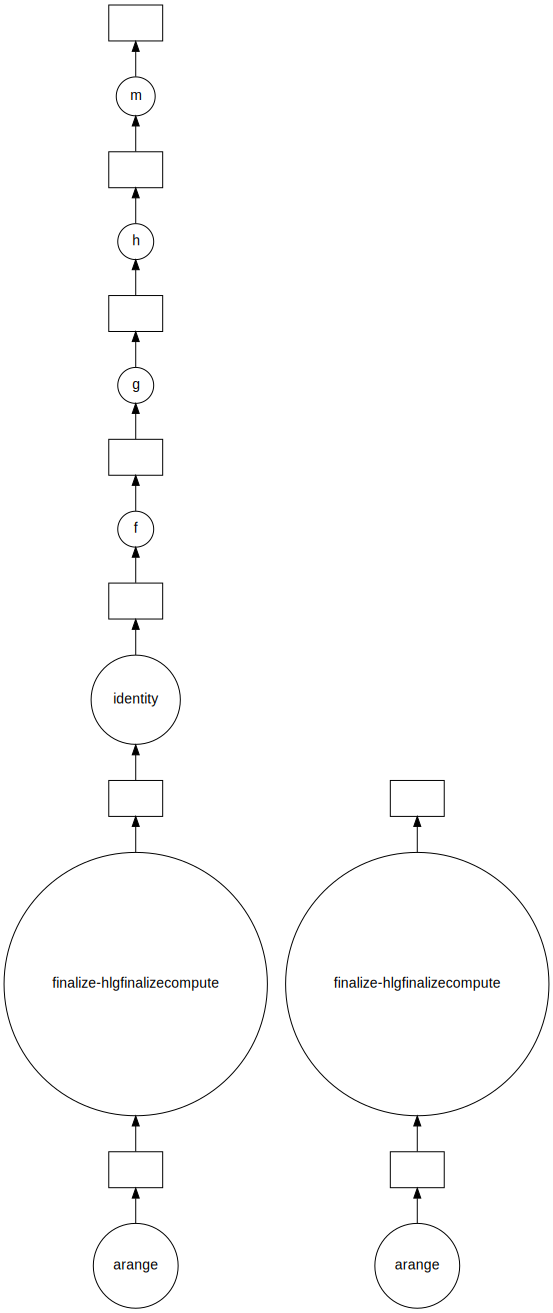

In [8]:
dask.visualize(computation, filename='dask_graph.svg', format='svg')
# Save the graph to a file

### Execute with dask

replace input with something more supstantial

In [9]:
og_data = np.random.rand(int(1e9))

wrap numpy array into dask array. only for the experiments here

In [10]:
input_data = da.from_array(og_data, chunks=(int(1e6),))

built the result by hand to be able to check it 

replace input of graph with new input and compute result 

In [ ]:
dask.config.set(scheduler='synchronous') # make ALL operations synchronous
graph[input_key] = input_data 
result = dask.get(graph, mx.key,).compute()
result

np.float64(-2.1029186884507914e-05)

try with parallel scheduler

In [ ]:
dask.config.set(scheduler='processes') 

graph[input_key] = input_data 
result = dask.get(graph, mx.key).compute()  # Use processes scheduler
result

np.float64(-2.1029186884507914e-05)

for dataframes, have a look [here](https://examples.dask.org/dataframe.html), for xarray, check [this](https://docs.xarray.dev/en/stable/user-guide/dask.html) out, and [that](https://examples.dask.org/xarray.html?highlight=schedulers) 

## Partial parallelization of a computational graph with `dask.annotate`

annotate `h` to be serial only

In [26]:

def h_single(x): 
    with dask.config.set(scheduler='synchronous'):
        hx =  h(x)
    return hx.rechunk('auto') # re-split the data again to make downstream operations parallel

h_delayed_serial = dask.delayed(h_single)

build up the graph again

In [27]:
input_placeholder = dask.delayed(identity, pure = True)(da.arange(2))
fx = f_delayed(input_placeholder)
gx = g_delayed(fx)
hx = h_delayed_serial(gx) # README: use the serial version of h
mx = m_delayed(hx)
input_key = input_placeholder.key
computation = mx 
graph = dict(computation.dask) 

execute the thing again with a parallel scheduler - check how the CPU load behaves.

In [28]:
dask.config.set(scheduler='processes')  # make operations parallel
graph[input_key] = input_data
result = dask.get(graph, computation.key).compute()  # Use processes scheduler
result

np.float64(-2.1029186884507904e-05)